In [30]:
#Modele MLP
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, f1_score
import joblib
import time


# CHARGEMENT des données prétraitées 

X = np.load("/kaggle/input/dataset-pre-traitement-sift-bovw-pca/X_pca.npy")
y = np.load("/kaggle/input/dataset-pre-traitement-sift-bovw-pca/y.npy")
with open("/kaggle/input/dataset-pre-traitement-sift-bovw-pca/label_names.pkl", "rb") as f:
    label_names = pickle.load(f)

print(f" X: {X.shape} | y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Train: {X_train.shape} | Test: {X_test.shape}")

# configuration du mlp avec OnevsRest
mlp = MLPClassifier(
    activation='relu',
    learning_rate_init=0.001,
    max_iter=500,  # ✅ 500 pour VRAIE convergence
    early_stopping=False,
    random_state=42,
    verbose=False
)

ovr = OneVsRestClassifier(mlp, n_jobs=-1)


#Parametres de grid search 
param_grid = {
    'estimator__hidden_layer_sizes': [(100, 50), (200, 100, 50)],
    'estimator__alpha': [0.0005]  # Fixé avec cette val pour gagner du temps 
}

cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


grid = GridSearchCV(
    ovr,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_micro',
    n_jobs=1,
    verbose=3
)

# LANCEMENT



start = time.time()
grid.fit(X_train_scaled, y_train)
train_time = time.time() - start


print(f" TERMINÉ en {train_time/60:.1f} min ")


# RÉSULTATS
print(f"\n Meilleurs paramètres:")
for k, v in grid.best_params_.items():
    print(f"   {k}: {v}")

print(f"\n Score CV: {grid.best_score_:.4f}")

results = grid.cv_results_
for i in range(len(results['params'])):
    print(f"\n   Config {i+1}:")
    print(f"      {results['params'][i]}")
    print(f"      Score: {results['mean_test_score'][i]:.4f}")
    print(f"      Temps: {results['mean_fit_time'][i]/60:.1f} min")

# PRÉDICTION
print("\n Prédiction ")
y_pred_base = grid.best_estimator_.predict(X_test_scaled)

try:
    y_pred_proba_list = grid.best_estimator_.predict_proba(X_test_scaled)
    
    if isinstance(y_pred_proba_list, list):
        y_pred_prob = np.zeros((len(X_test_scaled), len(y_pred_proba_list)))
        for i, prob_array in enumerate(y_pred_proba_list):
            if prob_array.ndim == 2 and prob_array.shape[1] > 1:
                y_pred_prob[:, i] = prob_array[:, 1]
            else:
                y_pred_prob[:, i] = 0.5
    else:
        y_pred_prob = y_pred_proba_list
    
    print("\n Seuils:")
    best_f1 = 0
    best_threshold = 0.5
    
    for t in [0.3, 0.4, 0.5]:
        y_p = (y_pred_prob >= t).astype(int)
        f1 = f1_score(y_test, y_p, average='micro', zero_division=0)
        marker = " " if f1 > best_f1 else "  "
        print(f"   {marker} {t}: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    
except:
    y_pred = y_pred_base
    best_threshold = 0.5

# ÉVALUATION
hamming = hamming_loss(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
subset_acc = np.all(y_pred == y_test, axis=1).mean()


print(" RÉSULTATS")

print(f"\n   Hamming:      {hamming:.4f}")
print(f"   F1 micro:     {f1_micro:.4f}  ")
print(f"   F1 macro:     {f1_macro:.4f}")
print(f"   Subset Acc:   {subset_acc:.4f}")

# SAUVEGARDE du modèle
joblib.dump(grid.best_estimator_, 'mlp_multilabel_model_optim.pkl')
joblib.dump(scaler, 'mlp_multilabel_scaler.pkl')

metadata = {
    'best_params': grid.best_params_,
    'best_cv_score': grid.best_score_,
    'label_names': label_names,
    'best_threshold': best_threshold,
    'train_time_minutes': train_time / 60,
    'test_metrics': {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'subset_accuracy': subset_acc,
        'hamming_loss': hamming
    }
}
joblib.dump(metadata, 'mlp_multilabel_metadata.pkl')

print("\n Modèle sauvegardé")


print(" TERMINÉ")

print(f"\n     Temps: {train_time/60:.1f} min")
print(f"    Config: {grid.best_params_}")
print(f"    F1: {f1_micro:.4f}")


    

 X: (8091, 100) | y: (8091, 495)
 Train: (6472, 100) | Test: (1619, 100)
Fitting 1 folds for each of 2 candidates, totalling 2 fits
[CV 1/1] END estimator__alpha=0.0005, estimator__hidden_layer_sizes=(100, 50);, score=0.078 total time= 6.2min
[CV 1/1] END estimator__alpha=0.0005, estimator__hidden_layer_sizes=(200, 100, 50);, score=0.068 total time=10.8min
 TERMINÉ en 24.5 min 

 Meilleurs paramètres:
   estimator__alpha: 0.0005
   estimator__hidden_layer_sizes: (100, 50)

 Score CV: 0.0782

   Config 1:
      {'estimator__alpha': 0.0005, 'estimator__hidden_layer_sizes': (100, 50)}
      Score: 0.0782
      Temps: 6.2 min

   Config 2:
      {'estimator__alpha': 0.0005, 'estimator__hidden_layer_sizes': (200, 100, 50)}
      Score: 0.0684
      Temps: 10.8 min

 Prédiction 

 Seuils:
     0.3: 0.0983
      0.4: 0.0941
      0.5: 0.0919
 RÉSULTATS

   Hamming:      0.0109
   F1 micro:     0.0983  
   F1 macro:     0.0091
   Subset Acc:   0.0000

 Modèle sauvegardé
 TERMINÉ

     Temps: 2

In [21]:
# Fonction pour générer une phrase gabarit

def generate_sentence_from_keywords(keywords, proba=None):
    # Cas où aucun mot-clé n'est détecté
    if len(keywords) == 0:
        return "No keywords detected"
    # Tri des mots-clés par probabilité si fournie
    if proba is not None:
        keywords = [kw for kw, _ in sorted(zip(keywords, proba), key=lambda x: x[1], reverse=True)]
    # Génération de la phrase selon le nombre de mots-clés    
    if len(keywords) == 1:
        return f"An image of {keywords[0]}"
    elif len(keywords) == 2:
        return f"An image showing {keywords[0]} and {keywords[1]}"
    elif len(keywords) == 3:
        return f"An image of {keywords[0]} with {keywords[1]} and {keywords[2]}"
    else:
        # Si plus de 3 mots-clés, on prend les trois premiers pour la phrase principale
        main_kw = ', '.join(keywords[:3])
        return f"An image featuring {main_kw} and {keywords[3]}"


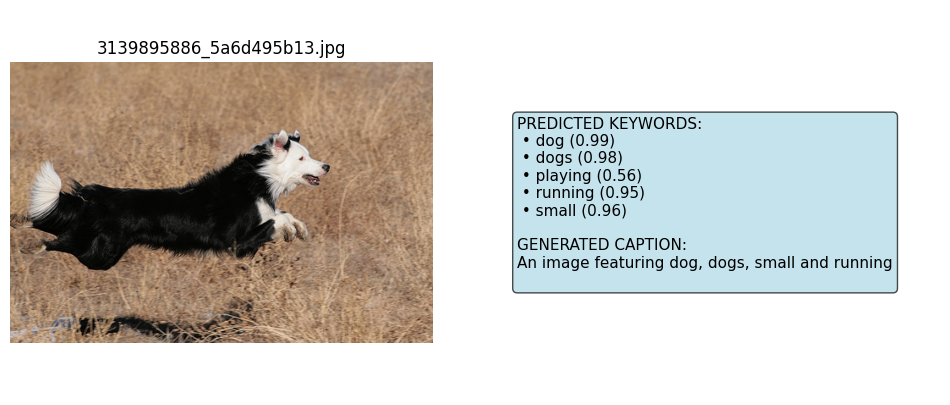

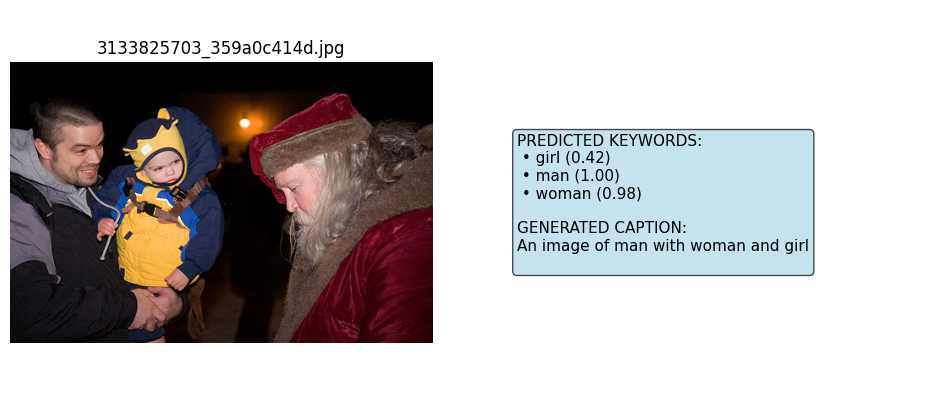

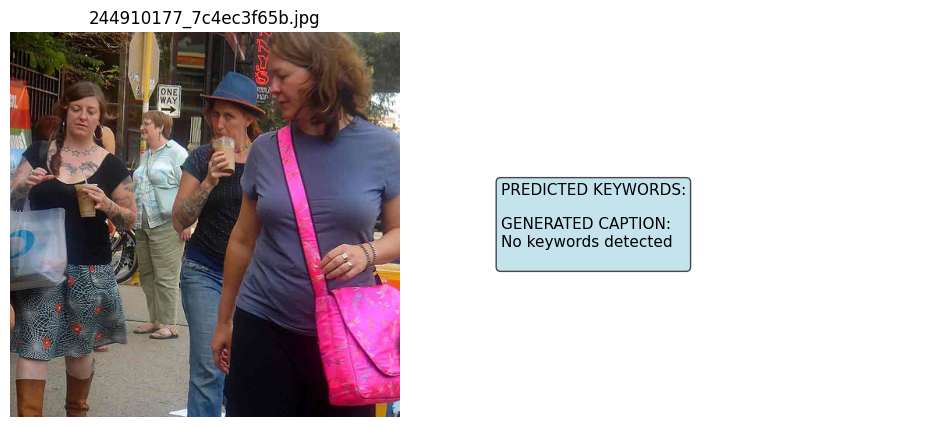

In [22]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

# -----------------------------
# CHEMIN DES IMAGES
# -----------------------------
IMAGE_DIR = "/kaggle/input/flickr8k/Images"
valid_image_names = os.listdir(IMAGE_DIR)
valid_image_names.sort()  # optionnel, pour un ordre stable

# -----------------------------
# PREPARATION DES NOMS POUR X_TEST
# -----------------------------
# Assurez-vous que X_test et image_names sont alignés après train_test_split
image_names_array = np.array(valid_image_names)
_, X_test_names = train_test_split(image_names_array, test_size=0.2, random_state=42)

# -----------------------------
# MultiLabelBinarizer pour récupérer les classes
# -----------------------------
mlb = MultiLabelBinarizer(classes=label_names)
mlb.fit([label_names])  # juste pour initialiser mlb.classes_

# -----------------------------
# Fonction d'affichage améliorée
# -----------------------------
def predict_and_display_improved(idx, X_test, y_test, y_pred, y_proba):
    # Extraction des labels prédits et vrais, ainsi que leurs probabilités
    pred_idx = np.where(y_pred[idx] == 1)[0]
    pred_labels = mlb.classes_[pred_idx]
    pred_probs = y_proba[idx][pred_idx] if y_proba is not None else None
    
    true_idx = np.where(y_test[idx] == 1)[0]
    true_labels = mlb.classes_[true_idx]
    
    # Chargement et préparation de l'image
    img_name = X_test_names[idx]  # correspondance X_test <-> nom image
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Cannot load image {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Génération de la légende à partir des mots-clés prédits
    caption = generate_sentence_from_keywords(list(pred_labels), pred_probs)
    
    # Affichage de l'image et des résultats 
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(img_name)
    
    plt.subplot(1,2,2)
    plt.axis('off')
    text = f"PREDICTED KEYWORDS:\n"
    if pred_probs is not None:
        for kw, p in zip(pred_labels, pred_probs):
            text += f" • {kw} ({p:.2f})\n"
    else:
        for kw in pred_labels:
            text += f" • {kw}\n"
    text += f"\nGENERATED CAPTION:\n{caption}\n"
    plt.text(0, 0.5, text, fontsize=11, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    plt.show()
    
    return pred_labels, caption, true_labels

# -----------------------------
# EXEMPLE D'AFFICHAGE
# -----------------------------
for i in range(min(3, len(X_test))):
    predict_and_display_improved(i, X_test_scaled, y_test, y_pred, y_pred_prob)


Segmentation avec K-means (k=5)...


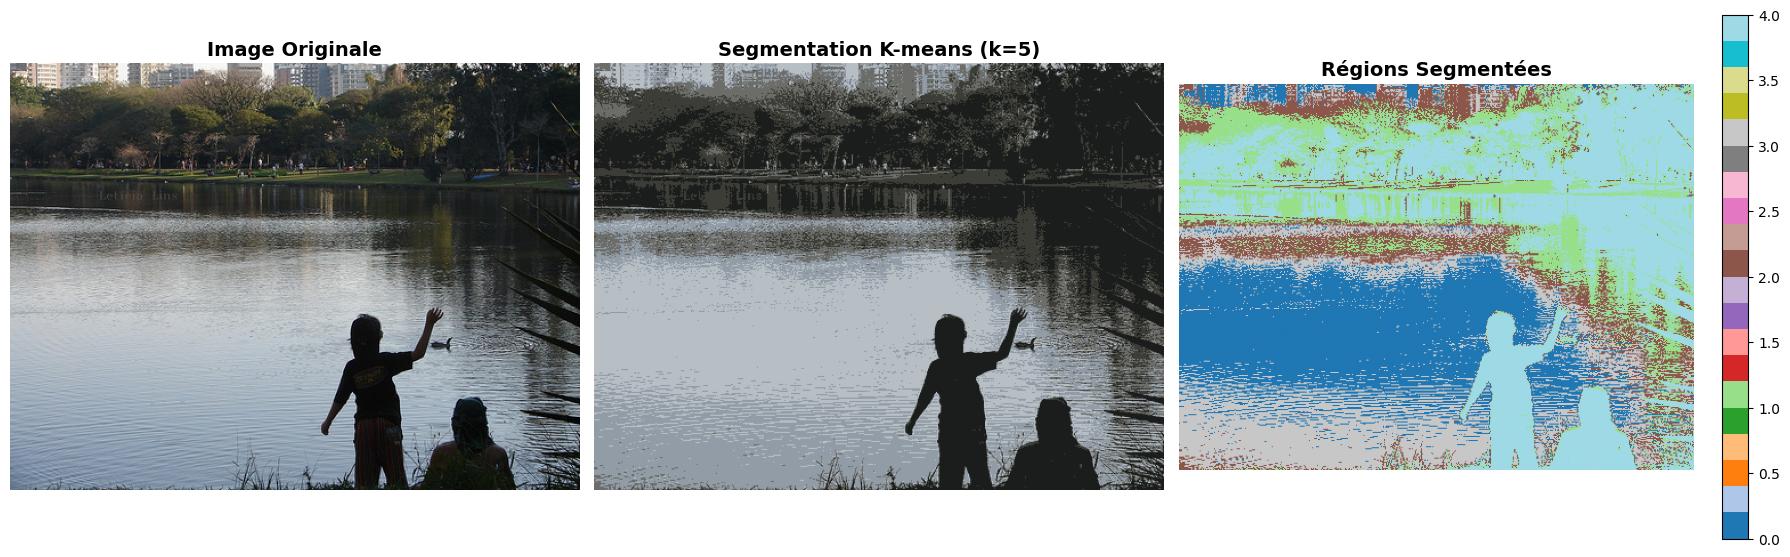


Nombre de segments: 5

Taille des segments (en pixels):
  Segment 0: 45810 pixels (24.43%)
  Segment 1: 29186 pixels (15.57%)
  Segment 2: 21439 pixels (11.43%)
  Segment 3: 36655 pixels (19.55%)
  Segment 4: 54410 pixels (29.02%)


In [24]:
from sklearn.cluster import KMeans

SegmentationKMeans = KMeans  # pour que ton code fonctionne


def segment_image_kmeans(image_path, n_segments=5, show_result=True):
    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: impossible de charger {image_path}")
        return None, None, None
    
    # Convertir BGR -> RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Obtenir les dimensions
    h, w, c = image_rgb.shape
    
    # Reshape: (height, width, 3) -> (height*width, 3)
    pixels = image_rgb.reshape(-1, 3)
    
    # Normaliser les valeurs des pixels [0, 255] -> [0, 1]
    pixels_normalized = pixels.astype(np.float32) / 255.0
    
    # Appliquer K-means
    print(f"Segmentation avec K-means (k={n_segments})...")
    kmeans_seg = SegmentationKMeans(
        n_clusters=n_segments,
        random_state=42,
        n_init=10,
        max_iter=300
    )
    
    labels = kmeans_seg.fit_predict(pixels_normalized)
    centers = kmeans_seg.cluster_centers_
    
    # Reconstruire l'image segmentée avec les centres de clusters
    segmented_pixels = centers[labels]
    segmented_image = (segmented_pixels * 255).reshape(h, w, c).astype(np.uint8)
    
    # Reshape labels pour avoir la forme de l'image
    labels_image = labels.reshape(h, w)
    
    if show_result:
        # Affichage
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Image originale
        axes[0].imshow(image_rgb)
        axes[0].set_title('Image Originale', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        # Image segmentée
        axes[1].imshow(segmented_image)
        axes[1].set_title(f'Segmentation K-means (k={n_segments})', fontsize=14, fontweight='bold')
        axes[1].axis('off')
        
        # Labels (régions)
        im = axes[2].imshow(labels_image, cmap='tab20')
        axes[2].set_title('Régions Segmentées', fontsize=14, fontweight='bold')
        axes[2].axis('off')
        plt.colorbar(im, ax=axes[2], fraction=0.046)
        
        plt.tight_layout()
        plt.show()
        
        # Statistiques
        unique_labels, counts = np.unique(labels, return_counts=True)
        print(f"\nNombre de segments: {len(unique_labels)}")
        print("\nTaille des segments (en pixels):")
        for label, count in zip(unique_labels, counts):
            percentage = (count / len(labels)) * 100
            print(f"  Segment {label}: {count} pixels ({percentage:.2f}%)")
    
    return segmented_image, labels_image, centers
    
seg_img1, labels1, centers1 = segment_image_kmeans(
    "/kaggle/input/flickr8k/Images/1022454332_6af2c1449a.jpg", 
    n_segments=5, 
    show_result=True
)

In [29]:
from collections import Counter

def calculate_bleu_scores(ref, hyp):
    # Fonction interne pour générer les n-grams d'une liste de tokens
    def ngrams(tokens, n):
        return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    scores = []
    # Calcul des BLEU-1 à BLEU-4
    for n in range(1,5):
        ref_ngrams = ngrams(ref, n) # n-grams de la référence
        hyp_ngrams = ngrams(hyp, n) # n-grams de la prédiction
        if len(hyp_ngrams)==0:
            scores.append(0)
        else:
            # Comptage des n-grams communs entre référence et prédiction
            overlap = sum(1 for g in hyp_ngrams if g in ref_ngrams)
            scores.append(overlap/len(hyp_ngrams))
    return scores

def calculate_cider_score(ref_kw, hyp_kw):
    if len(ref_kw)==0 or len(hyp_kw)==0:
        return 0 # Cas où l'un des ensembles est vide
    # Compteurs de fréquence des mots    
    ref_counter = Counter(ref_kw)
    hyp_counter = Counter(hyp_kw)
    all_words = set(ref_kw) | set(hyp_kw)
    # Création des vecteurs de fréquence pour référence et prédiction
    ref_vec = {w: ref_counter.get(w,0) for w in all_words}
    hyp_vec = {w: hyp_counter.get(w,0) for w in all_words}
    # Calcul du produit scalaire et de la norme pour la similarité cosinus
    dot = sum(ref_vec[w]*hyp_vec[w] for w in all_words)
    norm = (sum(v*v for v in ref_vec.values())**0.5) * (sum(v*v for v in hyp_vec.values())**0.5)
    # Retour du score CIDEr (normalisé sur 10)
    return (dot/norm)*10 if norm>0 else 0

bleu1_scores, bleu2_scores, bleu3_scores, bleu4_scores, cider_scores = [], [], [], [], []

for i in range(len(X_test)):
    # Extraction des mots-clés prédits et vrais
    pred_idx = np.where(y_pred[i]==1)[0]
    pred_kw = list(mlb.classes_[pred_idx])
    true_idx = np.where(y_test[i]==1)[0]
    true_kw = list(mlb.classes_[true_idx])
    # Calcul des scores BLEU
    b1, b2, b3, b4 = calculate_bleu_scores(true_kw, pred_kw)
    bleu1_scores.append(b1)
    bleu2_scores.append(b2)
    bleu3_scores.append(b3)
    bleu4_scores.append(b4)
    # Calcul du score CIDEr
    cider_scores.append(calculate_cider_score(true_kw, pred_kw))

print("\nCaption Metrics:")
print(f"BLEU-1: {np.mean(bleu1_scores):.4f}")
print(f"BLEU-2: {np.mean(bleu2_scores):.4f}")
print(f"BLEU-3: {np.mean(bleu3_scores):.4f}")
print(f"BLEU-4: {np.mean(bleu4_scores):.4f}")
print(f"CIDEr: {np.mean(cider_scores):.4f}")


Caption Metrics:
BLEU-1: 0.1341
BLEU-2: 0.0105
BLEU-3: 0.0020
BLEU-4: 0.0000
CIDEr: 0.8985
